    # ACC: Accuracy	-> (Number of Correct Predictions) / (Total Number of Predictions
    # FPR: False Positive Rate	-> Number of FP / (FP +TN)
    # AUC: Area under the ROC curve	-> scikit-learn
    # Ya: Yield of actives 	-> TP/(TP+FP)
    # EF: Enrichment Factor	-> ((TP)/(TP+FP))((tp+fn)/(tp+tn+fp+fn))
    # REF: Relative Enrichment Factor -> 100*tp/min(tp+fp,tp+fn)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc, confusion_matrix, ConfusionMatrixDisplay


import os 
from pathlib import Path

In [3]:
# paths
base_dir = Path(os.getcwd())/"implementation"
result_dir = base_dir / "data/results/COX1"
img_dir = Path(os.getcwd())/"docs/Thesis/images/cox1"


In [4]:
def calc_metrics_from_result_df(df: pd.DataFrame, name: str):
    label = df["LABEL"]
    pred = df["PRED"]

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for i, v in enumerate(pred):
        if v == 1 and label[i] == 1:
            true_positive += 1
        elif v == 1 and label[i] == 0:
            false_positive += 1
        elif v == 0 and label[i] == 0:
            true_negative += 1
        else:
            false_negative += 1

    resultdf = pd.DataFrame()
    resultdf["name"] = [name]
    resultdf["ACC"] = [(true_positive + true_negative) / len(label)]
    resultdf["FPR"] = [(false_positive) / (false_positive + true_negative)]
    resultdf["AUC"] = roc_auc_score(label, pred)
    resultdf["EF"] = [
        ((true_positive) / (true_positive + false_positive))
        / ((true_positive + false_negative) / (len(label)))
    ]
    resultdf["REF"] = [
        (100 * true_positive)
        / min((true_positive + false_positive), (true_positive + false_negative))
    ]
    return resultdf


def print_roc_curve(df: pd.DataFrame,path:Path):
    label = df["LABEL"]
    pred = df["PRED"]

    fpr, tpr, thresholds = roc_curve(label, pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(
        fpr=fpr,
        tpr=tpr,
        roc_auc=roc_auc,
        estimator_name="ROC Curve",
    )
    display.plot()
    #plt.show()
    plt.savefig(path)


def print_conf_matrix(df: pd.DataFrame,path:Path):
    label = df["LABEL"]
    pred = df["PRED"]
    label = ["active" if i == 1 else "inactive" for i in label]
    pred = ["active" if i == 1 else "inactive" for i in pred]

    cm = confusion_matrix(label, pred, labels=["active","inactive"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["active","inactive"])
    disp.plot()
    plt.savefig(path)

    


### load results


In [5]:
res = {
    "baseline_rf": pd.read_csv(result_dir / "baseline_rf.csv"),
    "baseline_nn": pd.read_csv(result_dir / "baseline_nn.csv"),
    "baseline_knn": pd.read_csv(result_dir / "baseline_knn.csv"),
    "fe_rf_mdi_knn": pd.read_csv(result_dir / "fe_rf_mdi_knn.csv"),
    "fe_rf_per_knn": pd.read_csv(result_dir / "fe_rf_per_knn.csv"),
    "fe_smote_rf": pd.read_csv(result_dir / "fe_smote_rf.csv"),
    "fe_smote_nn": pd.read_csv(result_dir / "fe_smote_nn.csv"),
}


In [6]:
r = pd.DataFrame()
for k, v in res.items():
    r = pd.concat([r, calc_metrics_from_result_df(v, name=k)])

r = r.sort_values("ACC", ascending=False)
print(
    r.to_latex(
        index=False,
        float_format="{:.4f}".format,
        escape=True,
        caption="Cyclooxygenase 1 performance test-set",
    )
)
r

\begin{table}
\caption{Cyclooxygenase 1 performance test-set}
\begin{tabular}{lrrrrr}
\toprule
name & ACC & FPR & AUC & EF & REF \\
\midrule
baseline\_rf & 0.7724 & 0.0183 & 0.6344 & 2.8909 & 87.0968 \\
fe\_smote\_rf & 0.7628 & 0.0138 & 0.6155 & 2.9362 & 88.4615 \\
fe\_rf\_per\_knn & 0.7019 & 0.0826 & 0.5598 & 1.7044 & 51.3514 \\
baseline\_knn & 0.6859 & 0.1147 & 0.5544 & 1.5153 & 45.6522 \\
baseline\_nn & 0.6827 & 0.0872 & 0.5309 & 1.4081 & 42.4242 \\
fe\_smote\_nn & 0.6827 & 0.1147 & 0.5490 & 1.4752 & 44.4444 \\
fe\_rf\_mdi\_knn & 0.6250 & 0.1835 & 0.4987 & 0.9899 & 29.8246 \\
\bottomrule
\end{tabular}
\end{table}



,name,ACC,FPR,AUC,EF,REF
0,baseline_rf,0.772436,0.018349,0.634443,2.890872,87.096774
0,fe_smote_rf,0.762821,0.013761,0.615460,2.936170,88.461538
0,fe_rf_per_knn,0.701923,0.082569,0.559779,1.704428,51.351351
0,baseline_knn,0.685897,0.114679,0.554363,1.515264,45.652174
0,baseline_nn,0.682692,0.087156,0.530890,1.408124,42.424242
0,fe_smote_nn,0.682692,0.114679,0.549044,1.475177,44.444444
0,fe_rf_mdi_knn,0.625000,0.183486,0.498682,0.989922,29.824561


baseline_rf
fe_smote_rf


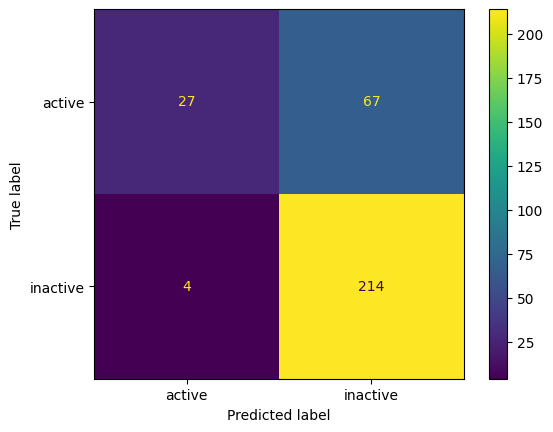

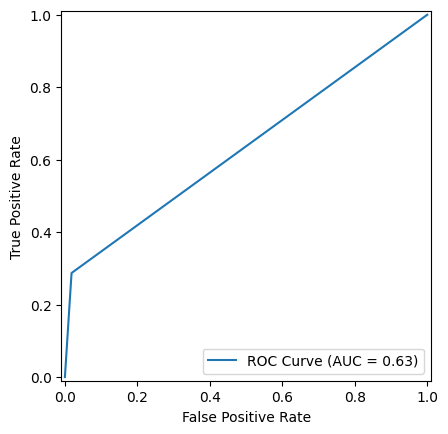

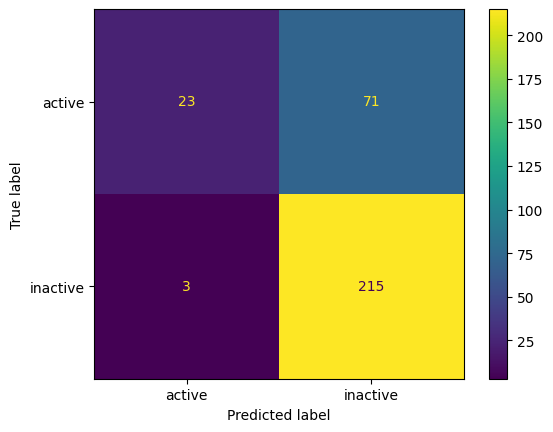

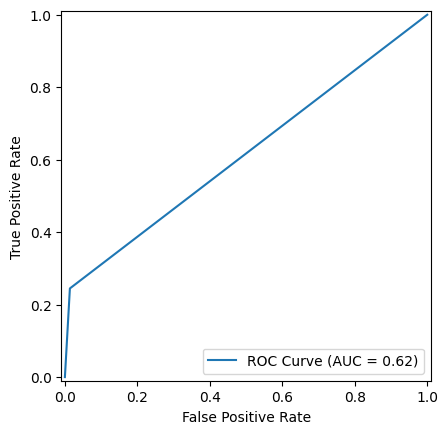

In [6]:
top_2 = ["baseline_rf","fe_smote_rf"]

for algo in top_2:
    print(algo)
    print_conf_matrix(res[algo],img_dir/f"{algo}_conf.jpg")
    print_roc_curve(res[algo],img_dir/f"{algo}_roc.jpg")